In [48]:
import pandas as pd
import numpy as np
import nltk 
import collections
from nltk.tokenize import RegexpTokenizer

In [95]:
import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
ann_file = '/Users/vassiki/Desktop/MIND/projects/sherlock/Sherlock_Segments_1000_NN_2017.xlsx'
ann_df = pd.read_excel(ann_file)

In [49]:
ann_list = ann_df['Scene Details - A Level '].tolist()

ann_words = [a.encode('ascii','ignore') for a in ann_list]

tokenizer = RegexpTokenizer(r'\w+')

tokens_list = [tokenizer.tokenize(a_string) for a_string in ann_words]
tokens = [t for tok in tokens_list for t in tok]

Now let's get rid of the stop words

In [113]:
from nltk.corpus import stopwords

stops = list(stopwords.words('english'))
lower_tokens = [t.lower() for t in tokens]
word_tokens = [w for w in lower_tokens if w not in stops]

print "We discarded {0} stop words".format(len(tokens)-len(word_tokens))

We discarded 8545 stop words


In [115]:
print ("Out of {0} words, {1} are unique." 
        " Let's looks at those first.".format(len(word_tokens), 
                                           len(set(word_tokens))))

Out of 10129 words, 2201 are unique. Let's looks at those first.


Workflow:

1. Find the thirty most commonly occuring words.
   Report how often they appear
2. Perform part of speech tagging for the bag of words
   Characterize the distribution of parts of speech

In [116]:
word_tokens[:10]

['people',
 'popcorn',
 'candy',
 'soft',
 'drink',
 'costumes',
 'parading',
 'crowd',
 'people',
 'singing']

In [117]:
counter=collections.Counter(word_tokens)
assert sum(counter.values()) == len(word_tokens)

In [118]:
common_words = counter.most_common(30)

### Plotting word frequency

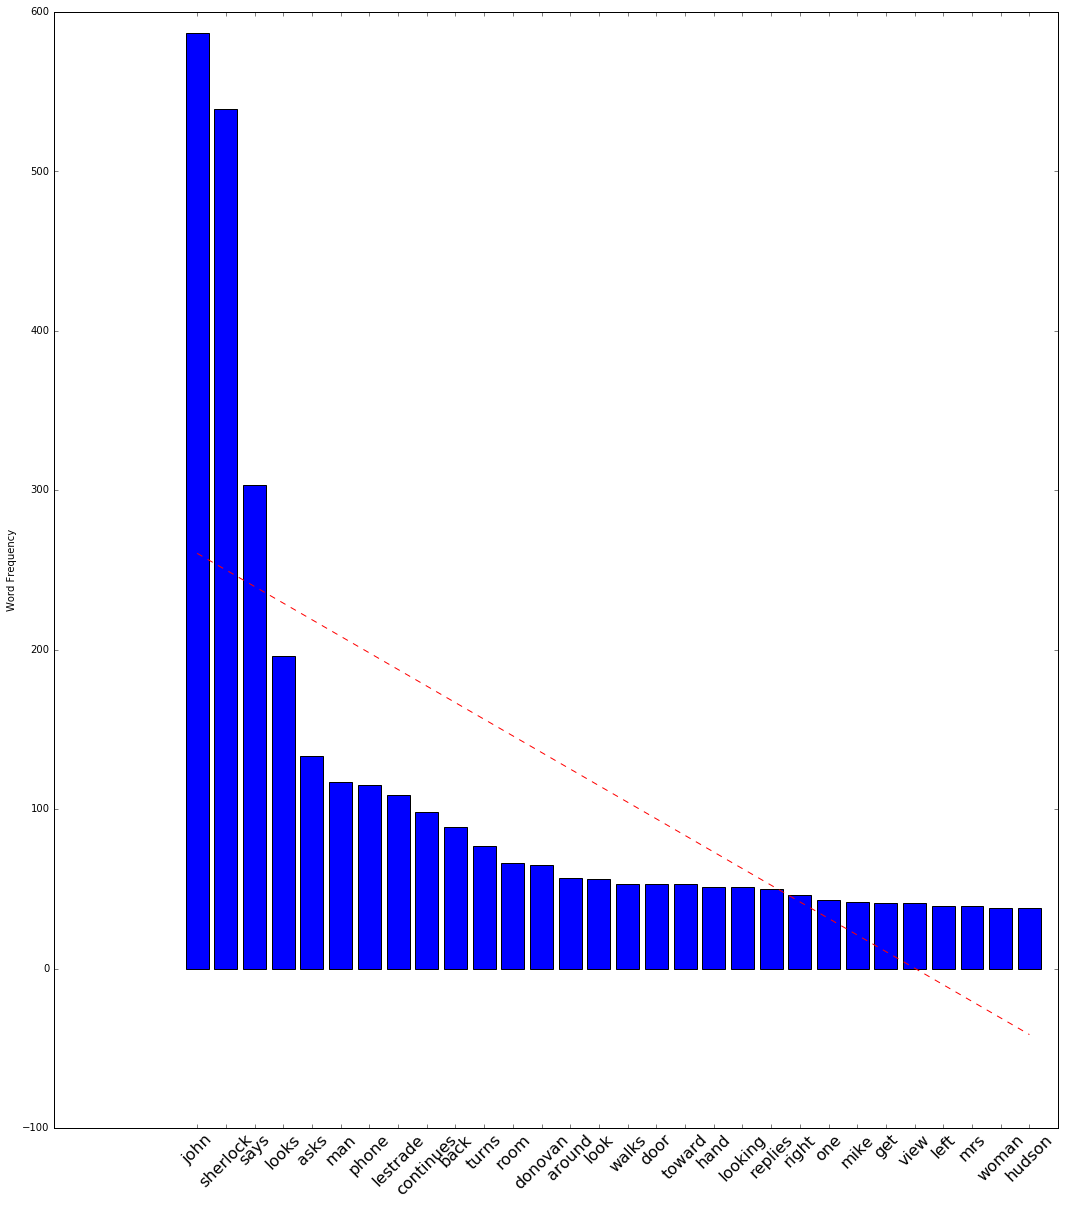

In [130]:
words = zip(*common_words)[0]
freq = zip(*common_words)[1]

x_pos = np.arange(len(words)) 

slope, intercept = np.polyfit(x_pos, freq, 1)
trendline = intercept + (slope * x_pos)

plt.figure(figsize=(18,20))
plt.xticks(fontsize=16, rotation=45)

plt.plot(x_pos, trendline, color='red', linestyle='--')    
plt.bar(x_pos, freq,align='center')

plt.xticks(x_pos, words) 
plt.ylabel('Word Frequency')
plt.show()

In [131]:
# just working with unique words

only_unique_words = list(set(word_tokens))
tagged_words = nltk.pos_tag(only_unique_words)

In [169]:
tagged_words
pos_labels = [pos[1] for pos in tagged_words]
assert len(pos_labels) == len(tagged_words)

pos=collections.Counter(pos_labels)
counter_pos = [(p,pos[p]) for p in pos]

### Plotting part of speech frequency

In [171]:
labels = zip(*counter_pos)[0]
freq = zip(*counter_pos)[1]

In [172]:
x_pos = np.arange(len(labels)) 

slope, intercept = np.polyfit(x_pos, freq, 1)
trendline = intercept + (slope * x_pos)

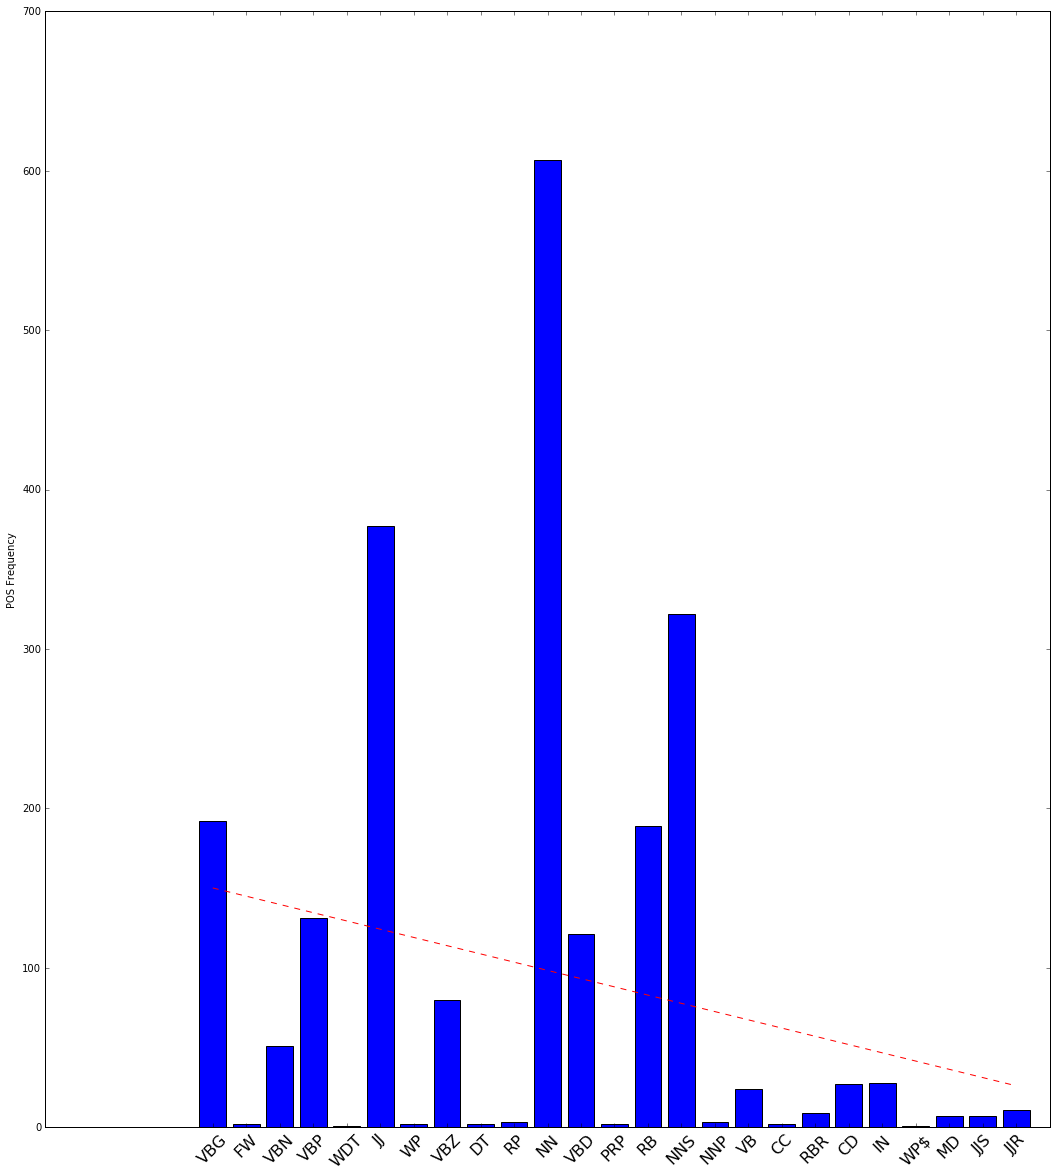

In [174]:
plt.figure(figsize=(18,20))
plt.xticks(fontsize=16, rotation=45)

plt.plot(x_pos, trendline, color='red', linestyle='--')    
plt.bar(x_pos, freq,align='center')

plt.xticks(x_pos, labels) 
plt.ylabel('POS Frequency')
plt.show()

### Workflow for 08/02:

1. Find vecorized representations of all the words from the annotation
2. Try to use the TR segment onset annotations to create a dataset similar 
   to Alex Huth's formalism 

Basically, try to get as far as before training the regression model

In [8]:
# load trained words
import pandas as pd
glove_vocab = pd.read_table('/Users/vassiki/Desktop/MIND/projects/'
                            'scratch/GloVe-1.2/vocab.txt',header=None)
glove_vocab.columns = ['vocab']

In [10]:
words_and_freqs = glove_vocab['vocab'].tolist()
wl = [s.split(" ")[0] for s in words_and_freqs]

In [46]:
# load trained feature vectors
glove_features = pd.read_table('/Users/vassiki/Desktop/MIND/projects/'
                            'scratch/GloVe-1.2/vectors.txt',header=None)
glove_features.columns = ['vectors']

words_and_vecs = glove_features['vectors'].tolist()
vecs = [s.split(" ")[1:] for s in words_and_vecs]
wl = [s.split(" ")[0] for s in words_and_vecs]
# dimension of each vector is 50 

In [ ]:
# put the vocabulary and vectors together in a data frame
lookup = pd.DataFrame({'words': wl, 'vectors': vecs})

In [162]:
# get the column with words from sherlock
ann_df.head()

df = ann_df.copy()
# remove non ascii chars

# first clean up words in the rows
df["Words"] = ""
#for idx,row in enumerate(df['Scene Details - A Level ']):
for idx in range(df.shape[0]):
    row = df['Scene Details - A Level '][idx]
    if pd.isna(row):
        iter_row = str(row)
    else:
        iter_row = row.encode('ascii','ignore')
    #df.at[idx,"Words"] = [a.encode('ascii','ignore') 
    #                      for a in iter_row.split(" ")]
    asciify = [a.encode('ascii','ignore') 
                          for a in iter_row.split(" ")]
    
    # create tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    tokens_list = [tokenizer.tokenize(a_string) for a_string in asciify]
    tokens = [t for tok in tokens_list for t in tok]
    df.at[idx,"Words"] = tokens

In [175]:
# get feature vectors for each word in each row
just_words = df["Words"].tolist()

for firstrow in just_words:
    for w in firstrow:
        if w.lower() in lookup['words'].tolist():
            print w, 'here'
        else:
            print w, 'not here'

People here
in here
popcorn here
candy here
and here
soft here
drink here
costumes here
are here
parading not here
down here
a here
crowd here
of here
people here
singing here
Let here
s here
all here
go here
to here
the here
lobby here
x here
3 not here
to here
get here
ourselves here
a here
treat here
Popcorn here
is here
being here
popped here
in here
a here
large here
popcorn here
machine here
made here
of here
glass here
A here
young here
woman here
sings here
Delicious here
things here
to here
eat here
Men here
sing here
in here
reply here
the here
popcorn here
can here
t here
be here
beat here
A here
family here
of here
four here
a here
father here
with here
a here
black here
suit here
a here
little here
boy here
with here
a here
striped here
shirt here
his here
older here
sister here
with here
a here
red here
shirt here
and here
red here
hair here
and here
red here
bow here
as here
well here
as here
a here
mother here
with here
a here
green here
shirt here
and here
grey here
sk

In [ ]:
# add them up